# The 22 Charts of 2022 - Part 1

In this set of notebooks we present the code for 22 charts that showcase the events that most caught our attention during 2021 and which we should keep looking out for in 2022, focusing on the following topics:

* Macroeconomic
* Fintech space
* Tourism
* Banking and capital markets

In this first part of the series, we'll focus on the charts related to the macroeconomic environment in Mexico.

To start let's make the basic imports so we can easily work with TUKAN's API and our `matplotlib` stylesheet.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
import seaborn as sns

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

ModuleNotFoundError: No module named 'seaborn'

Since we'll be working with maps, we'll also load the INEGI shapefile which can be found in the `assets` directory and we'll need to import the `geopandas` package.

**Tip:** if you're using a Windows machine and are having trouble installing `geopandas` referr to [this article](https://iotespresso.com/how-to-install-geopandas-on-windows/).

In [2]:
import geopandas as gpd

Now that we have `geopandas` installed we load INEGI's municipality shapefile, and a `csv` file that contains a mapping for TUKAN's geography id's and INEGI's municipality codes.

In [3]:
df_mun = gpd.read_file("../../../assets/maps/00mun.shp")
# df_edo = gpd.read_file("../../../assets/maps/00ent.shp")

#INEGI - TUKAN geography mapping

inegi_tukan_map = pd.read_csv('../../../assets/maps/inegi_geography_map.csv', dtype={'CVEGEO':'str'})

# And we apply the mapping to the shapefile

df_mun = pd.merge(df_mun, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')
# df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')

#Rename columns
df_mun.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)
# df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)

## Chart 1: Census Population Density

In this chart we'll visualize population density across the country using the Mexican census data which was released at the start of this year.

Let's go ahead and load the data that we'll be using in this particular viz.

In [93]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "geography": "all",
        "sex": [
            "fb2fa3c93cb0a9e"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_census_people",
            "variables": [
                "092220561a5c1b6"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)

Success getting the data


In [94]:
census_data = response["data"]

# # We merge with the INEGI shapefile.

census_data_aux = pd.merge(df_mun, census_data, how = "left", on = "geography__ref").reset_index(drop = True)

First we are going to check the `crs` of the GeoDataFrame and change it to a Cartesian system (EPSG:3857, unit = meter) so we can compute the area of each municipality. 

In [95]:
census_data_aux = census_data_aux.to_crs('epsg:3857')

In [96]:
census_data_aux.loc[:,"area"] = census_data_aux['geometry'].area/ 10**6

Now we can compute the total population per square kilometer.

In [97]:
census_data_aux.loc[:,"density"] = census_data_aux["092220561a5c1b6"]/census_data_aux["area"]

In [11]:
plot_data = pd.merge(df_mun, census_data_aux[["geography__ref", "density"]], how = "left", on = "geography__ref").reset_index(drop = True)

ipykernel_launcher:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
ipykernel_launcher:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


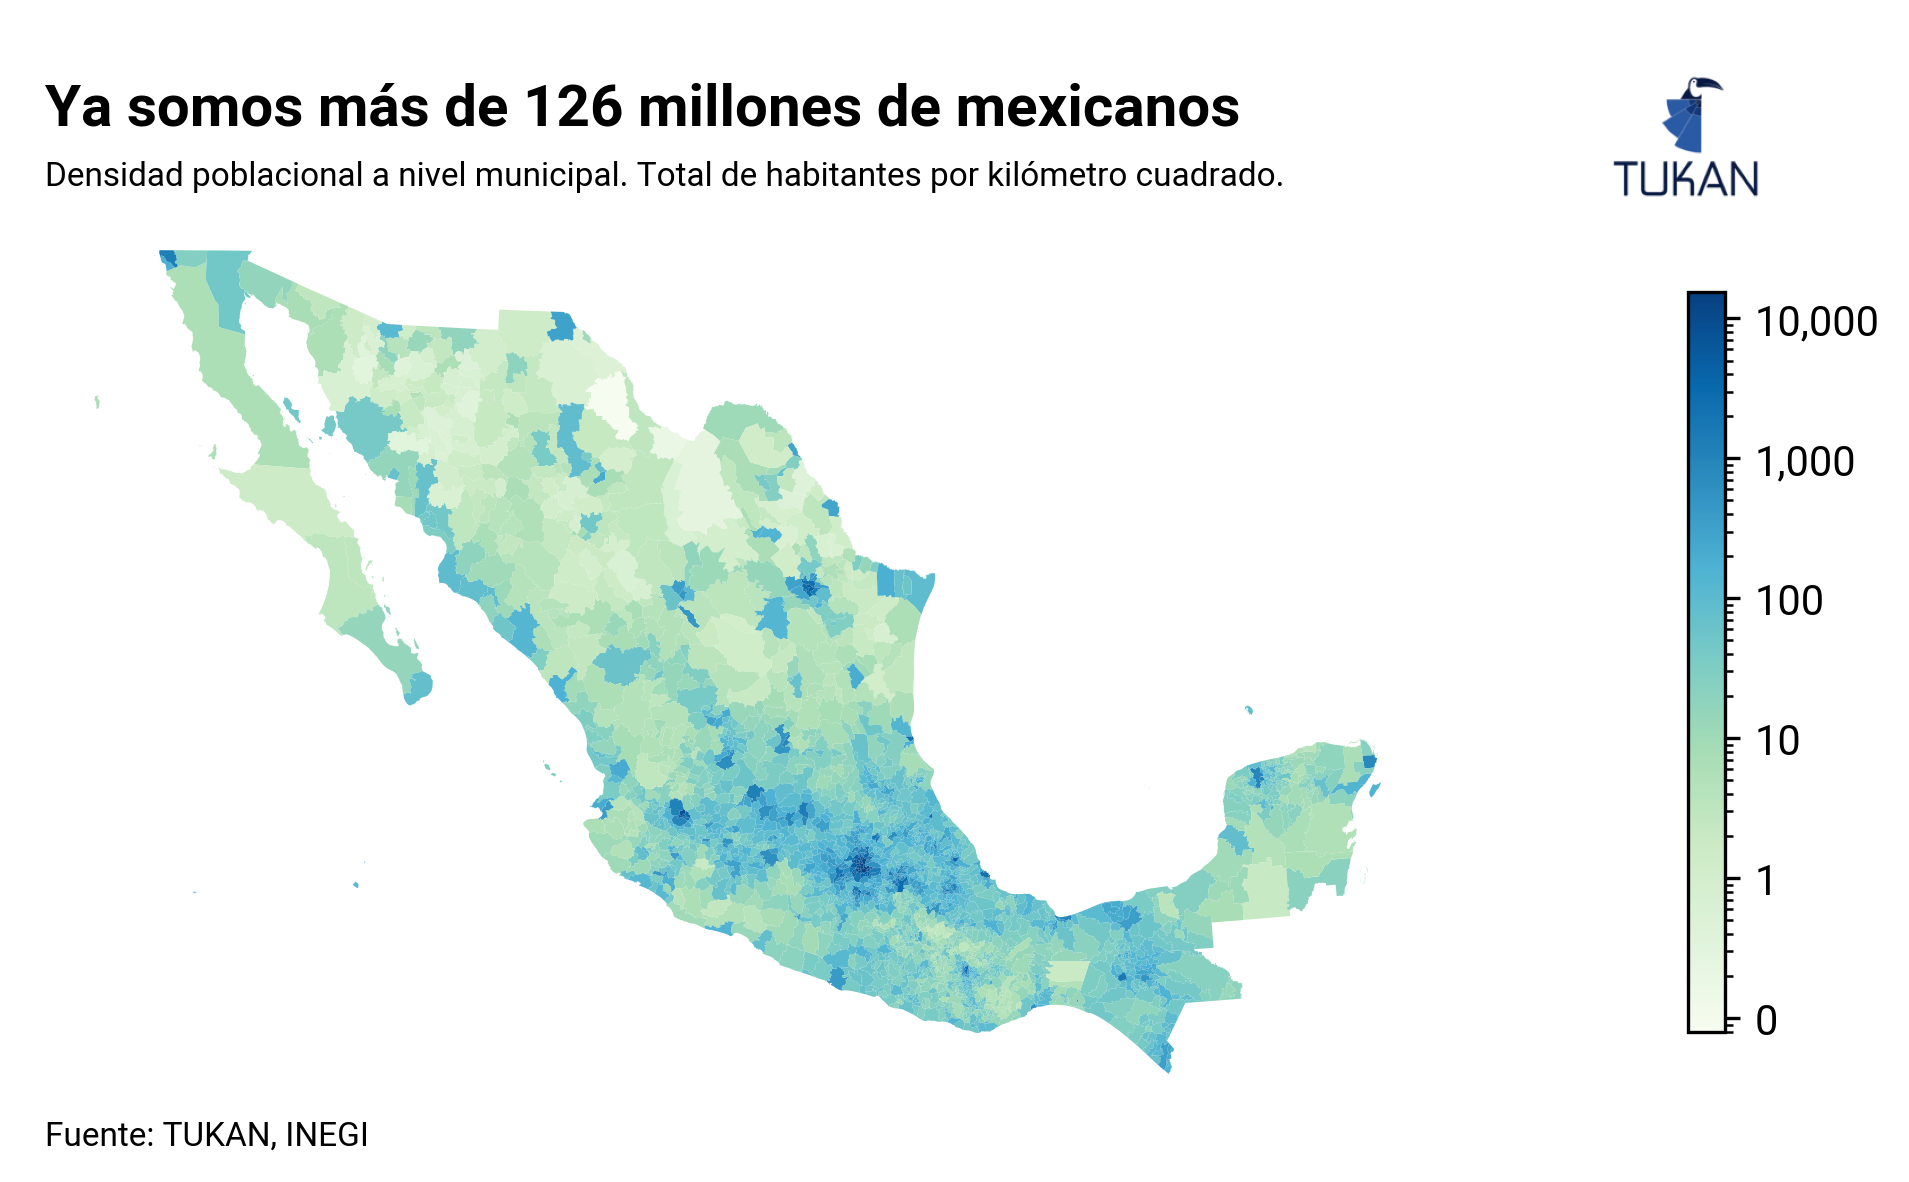

In [64]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05]
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


plot_data.plot("density", norm=mpl.colors.LogNorm(vmin=plot_data.density.min(), vmax=plot_data.density.max()), ax = ax1, cmap = "GnBu")

# --- Dummy heatmap
heatmap=ax2.imshow([plot_data.density], cmap = "GnBu", norm=mpl.colors.LogNorm(vmin=plot_data.density.min(), vmax=plot_data.density.max()))
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:,.0f}'), ax = ax2)


fig.text(
    0.2,
    .95,
    "Ya somos más de 126 millones de mexicanos",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Densidad poblacional a nivel municipal. Total de habitantes por kilómetro cuadrado.",
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()

plt.savefig(
    "plots/pop_density_transparent_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")




plt.savefig(
    "plots/pop_density_transparent_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/pop_density_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)


## Chart 2: Gross Domestic Product

The negative economic impact caused by the pandemic as well its recovery, has been different for each economic activity. As a result of social distancing measures and the supply chain issues present in the world, some industries have not yet recovered from their 2019 benchmark.

Let's visualize the relative difference in GDP levels between 2021 and 2019 for each economic activity in Mexico, in order to discover which of them have already surpassed its 2019 levels and by how much. 

In [103]:
# Main payload
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "6b36ca46b6cfd91",
            "457155464609a2f",
            "36348912d8470dd",
            "faa2a8d0af8a72c",
            "be676b5dd921cb7",
            "f5adaadda584ca7",
            "e426cc87d0540ab",
            "afcc312ccddfcc1",
            "990b94ebe38c9ca",
            "d35f5b82779e7d5",
            "3726993cc9fecab",
            "bbb49ae78601ab9",
            "4bc9836c2d7e60a",
            "fcb303b72a98f6c",
            "d05c3b2b73d75fc",
            "44d246411040129",
            "a07267f78158c2c",
            "feb7bb4445c808d",
            "169c33ccdd66d77",
            "23cf92d98dd7c11"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_gdp_national",
            "variables": [
                "675882bced9ce54"
            ]
        }
    ],
    "from": "2019-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


Here we compute the cumulative GDP for both years and adjust the labels for our viz.

In [104]:
# Data
gdp = response["data"]

# Remove the quarters from previous years that are not available yet for the current year
date_filter = gdp['date'].max().month
gdp = gdp[gdp["date"].dt.month<= date_filter]

# Calculate the cumulative GDP for each year and economic activity, dividing it by a million 
gdp = gdp.groupby([gdp.date.dt.year,'economic_activity__ref','economic_activity']).sum().reset_index()
gdp['675882bced9ce54'] = gdp['675882bced9ce54']/1000000

# Pivot the data frame so it is easy to plot, calculate the variation between 2021-2019 and sort ascendingly according to it
gdp = gdp.pivot(index = 'economic_activity', columns='date', values='675882bced9ce54').reset_index()
gdp['var_2021_2019'] =  (gdp[2021] / gdp[2019])-1
gdp = gdp.sort_values('var_2021_2019', ascending=True)
gdp['p_ref'] =  range(gdp.shape[0]) #plot_reference

# Rename the tickers to improve plot design
gdp = gdp.replace({'Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos':'Serv. de esparcimiento y recreativos',
                   'Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final':'Energía, suministro de agua y gas natural',
                   'Servicios de alojamiento temporal y de preparación de alimentos y bebidas':'Hoteles y Restaurantes',
                   'Otros servicios excepto actividades gubernamentales':'Otros servicios',
                   'Agricultura, cría y explotación de animales, aprovechamiento forestal, pesca y caza':'Agricultura, ganadería, pesca y acts. forestales',
                   'Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación':'Serv. de apoyo a los negocios y manejo de residuos',
                   'Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales':'Acts. gubernamentales y legislativas',
                   'Servicios inmobiliarios y de alquiler de bienes muebles e intangibles':'Serv. inmobiliarios y alquiler de bienes',
                   'Servicios de salud y de asistencia social':'Serv. sociales y de salud',
                   'Servicios profesionales, científicos y técnicos':'Serv. profesionales, científicos y técnicos',
                   'Servicios educativos':'Serv. educativos',
                   'Servicios financieros y de seguros':
                   'Serv. financieros y de seguros'
 })
gdp.reset_index(drop=True, inplace=True)

Now to the fun part, plot time!  

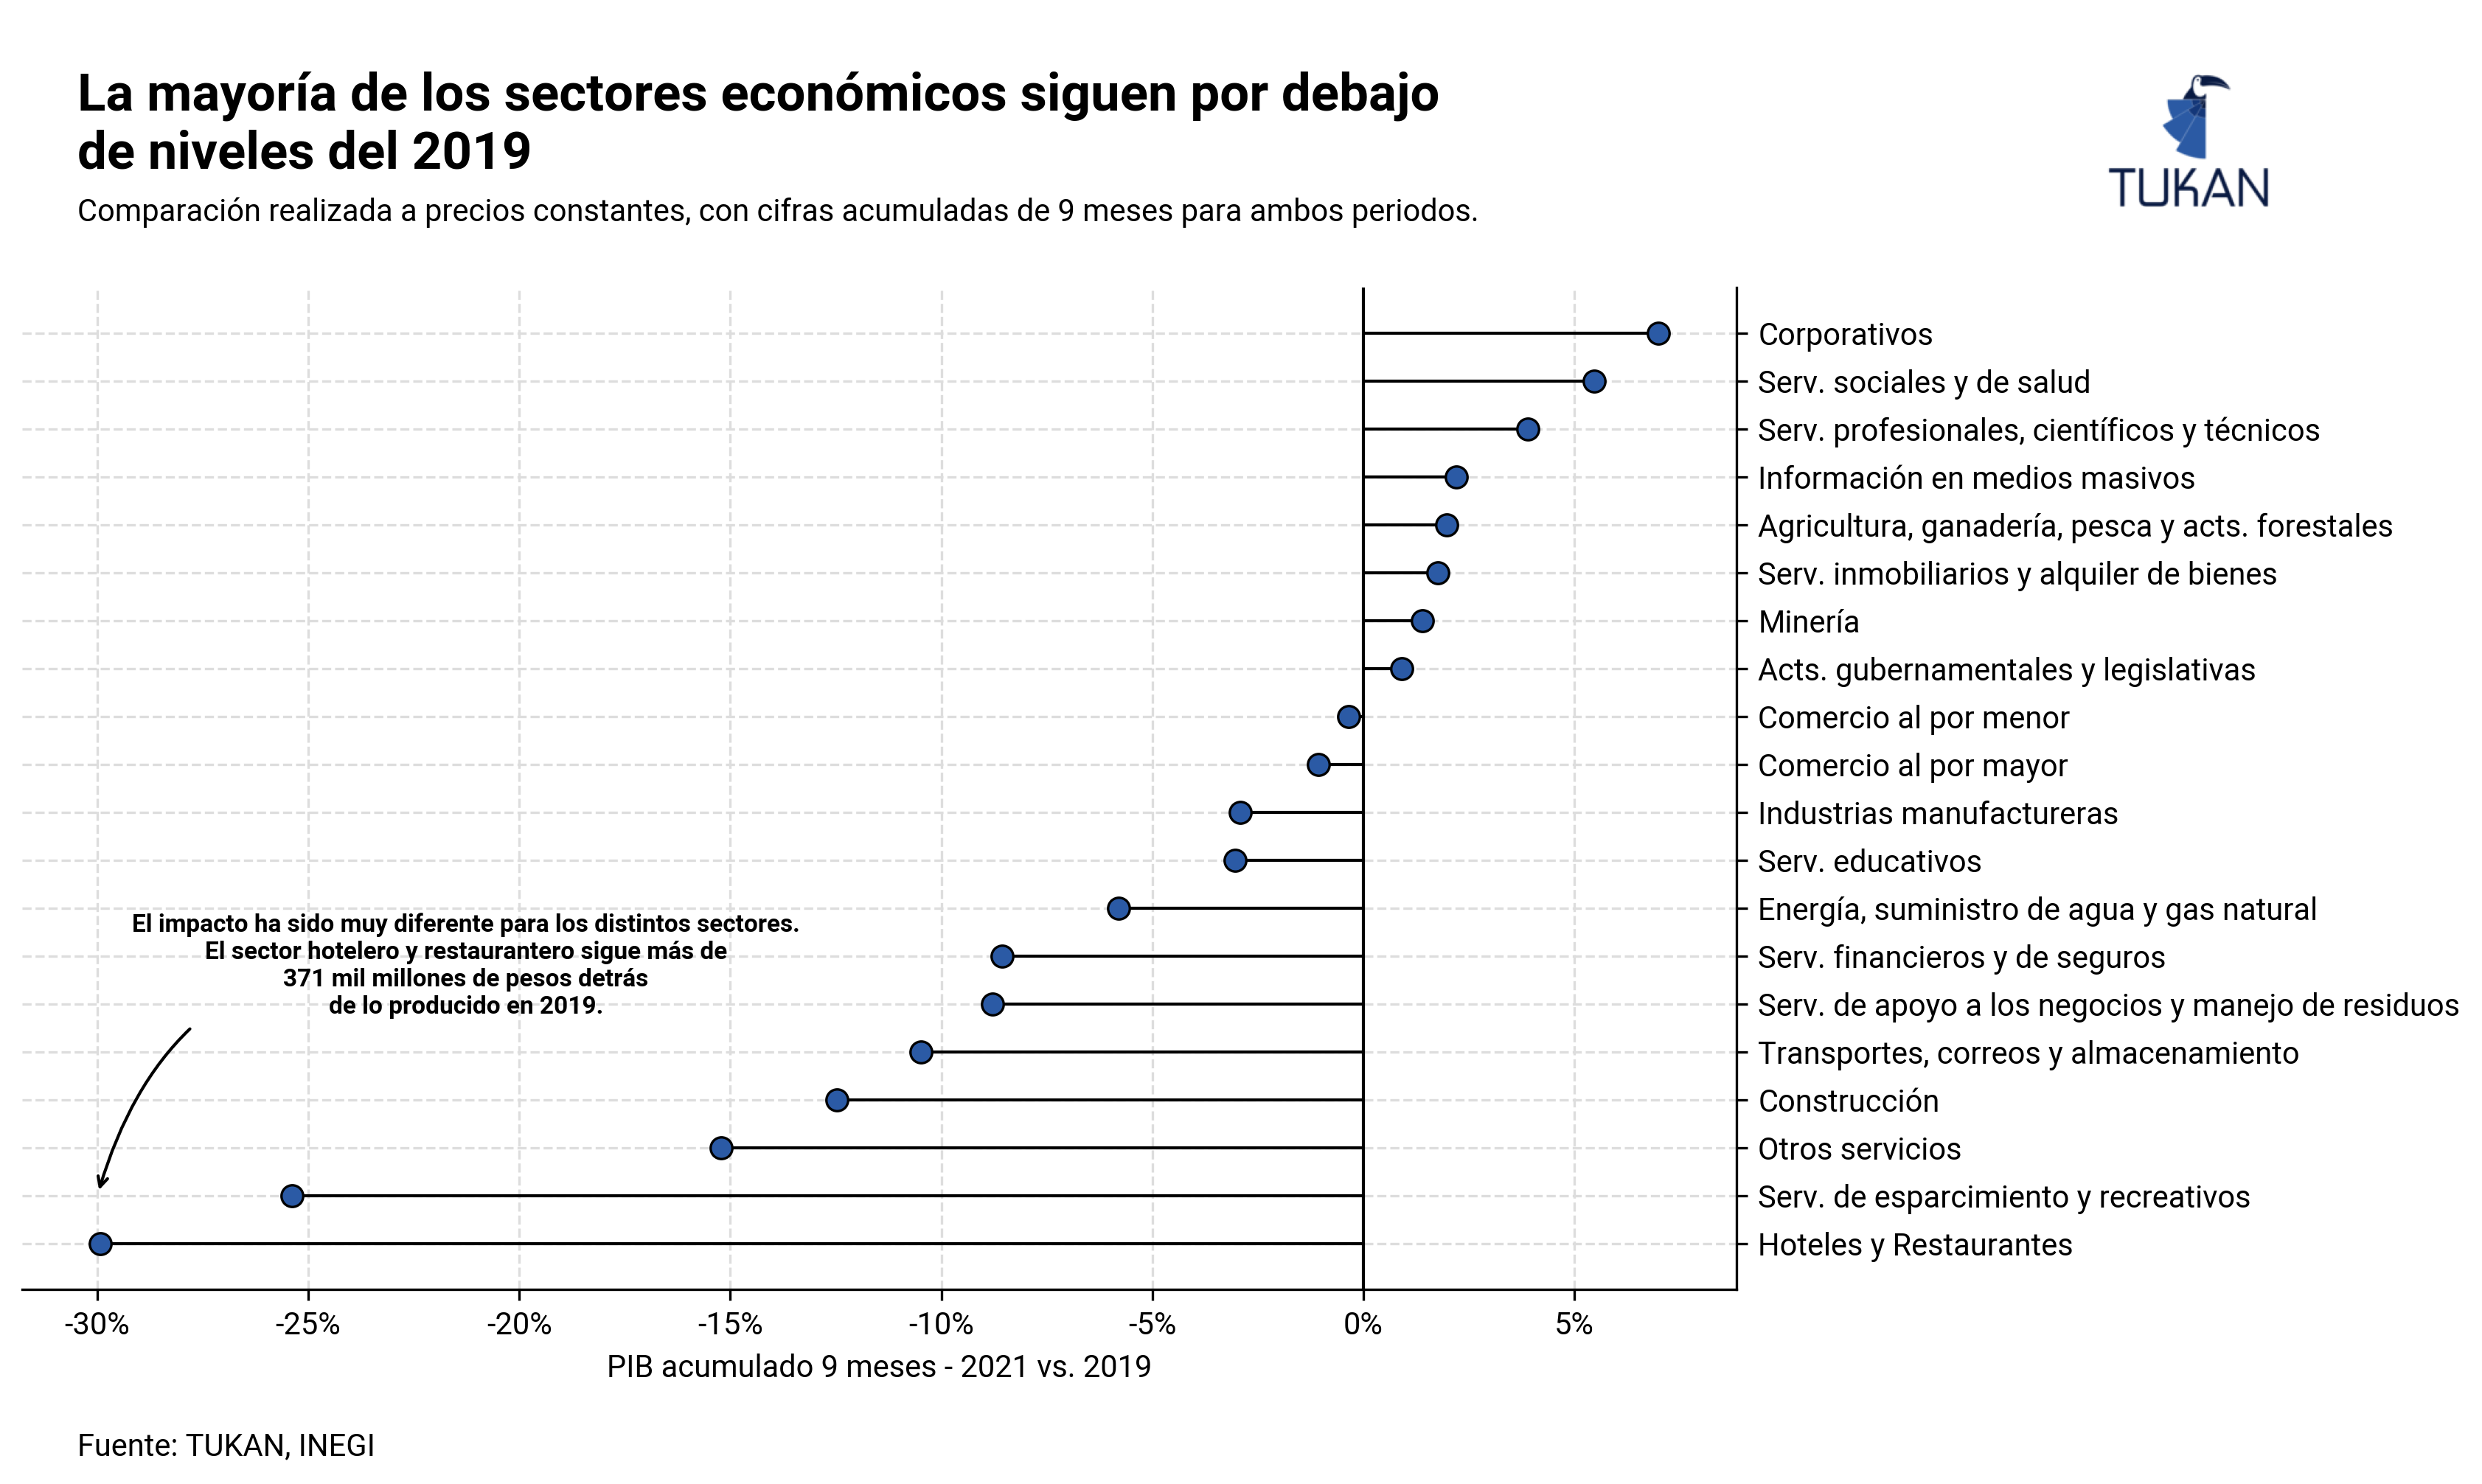

In [105]:
labels = gdp['economic_activity'].tolist()

fig = plt.figure(figsize=(10,6), dpi = 300)
ax = plt.subplot(111)

# Change splines
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(False)

# Data to plot
for x in gdp.index:
    if gdp['var_2021_2019'].loc[x]>=0:
        ax.hlines(y=gdp['p_ref'].loc[x], xmin=0, xmax=gdp['var_2021_2019'].loc[x],lw=1, color='black' ,zorder=2)
    else:
        ax.hlines(y=gdp['p_ref'].loc[x], xmin=gdp['var_2021_2019'].loc[x], xmax=0,lw=1, color='black' ,zorder=2)
ax.scatter(gdp['var_2021_2019'],gdp['p_ref'],s=50, edgecolors='black', lw=0.8, zorder=3, label='2021')

# Add gridlines and format to ticks 
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.axvline(x=0,lw=1, color='black')
ax.set_yticks(range(gdp.shape[0]))
ax.set_yticklabels(labels)

# Axis ticks on right side
ax.yaxis.tick_right()

ax.set_xlabel("PIB acumulado 9 meses - 2021 vs. 2019")

# Annotation for hotels

ax.annotate(
    "El impacto ha sido muy diferente para los distintos sectores.\nEl sector hotelero y restaurantero sigue más de\n371 mil millones de pesos detrás\nde lo producido en 2019.",
    xy=(-.3,
        1),
    xycoords="data",
    xytext=(120, 75),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.45"
    ),
)

# Add title and subtitle
fig.text(
    0.15,
    .97,
    "La mayoría de los sectores económicos siguen por debajo \nde niveles del 2019",
    size=17,
    weight = "bold"
)

fig.text(
    0.15,
    0.93,
    "Comparación realizada a precios constantes, con cifras acumuladas de 9 meses para ambos periodos.",
    size=10
)

# Add footer
fig.text(0.15, -0, "Fuente: TUKAN, INEGI", fontsize=10)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/gdp_pandemic_recovery_economic_activity_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

#Tukey's Swag
tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([1, .9, 0.16, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/gdp_pandemic_recovery_economic_activity_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/gdp_pandemic_recovery_economic_activity_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 3: Inflation Time-series

This year has been characterized by the highest inflation rates since the beggining of the beginning of the 2000's, and some analyst expect to see high inflation rates well into 2022.


In [4]:
# Main payload
payload ={
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "dfeefc621d16d0c"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_inpc_scian_monthly",
            "variables": [
                "c572db59b8cd109"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

NameError: name 'get_tukan_api_request' is not defined

Let's transform the data frame to make a heat map plot

In [115]:
inflation = response["data"]
# inflation['year'] = inflation['date'].dt.year
# inflation['month'] = inflation['date'].dt.month
# inflation = inflation.pivot(index='month',columns='year',values='c572db59b8cd109').reset_index(drop=True)
# month_ticks = inflation.index.tolist()
# month_labels = {0:'Ene', 1:'Feb',2:'Mar',3:'Abr',4:'May',5:'Jun',6:'Jul',7:'Ago',8:'Sep',9:'Oct',10:'Nov',11:'Dic'}
# def replace(list, dictionary):
#     return [month_labels.get(item, item) for item in list]
# month_ticks = replace(month_ticks,month_labels)

# year_ticks = inflation.columns.tolist()[0:]

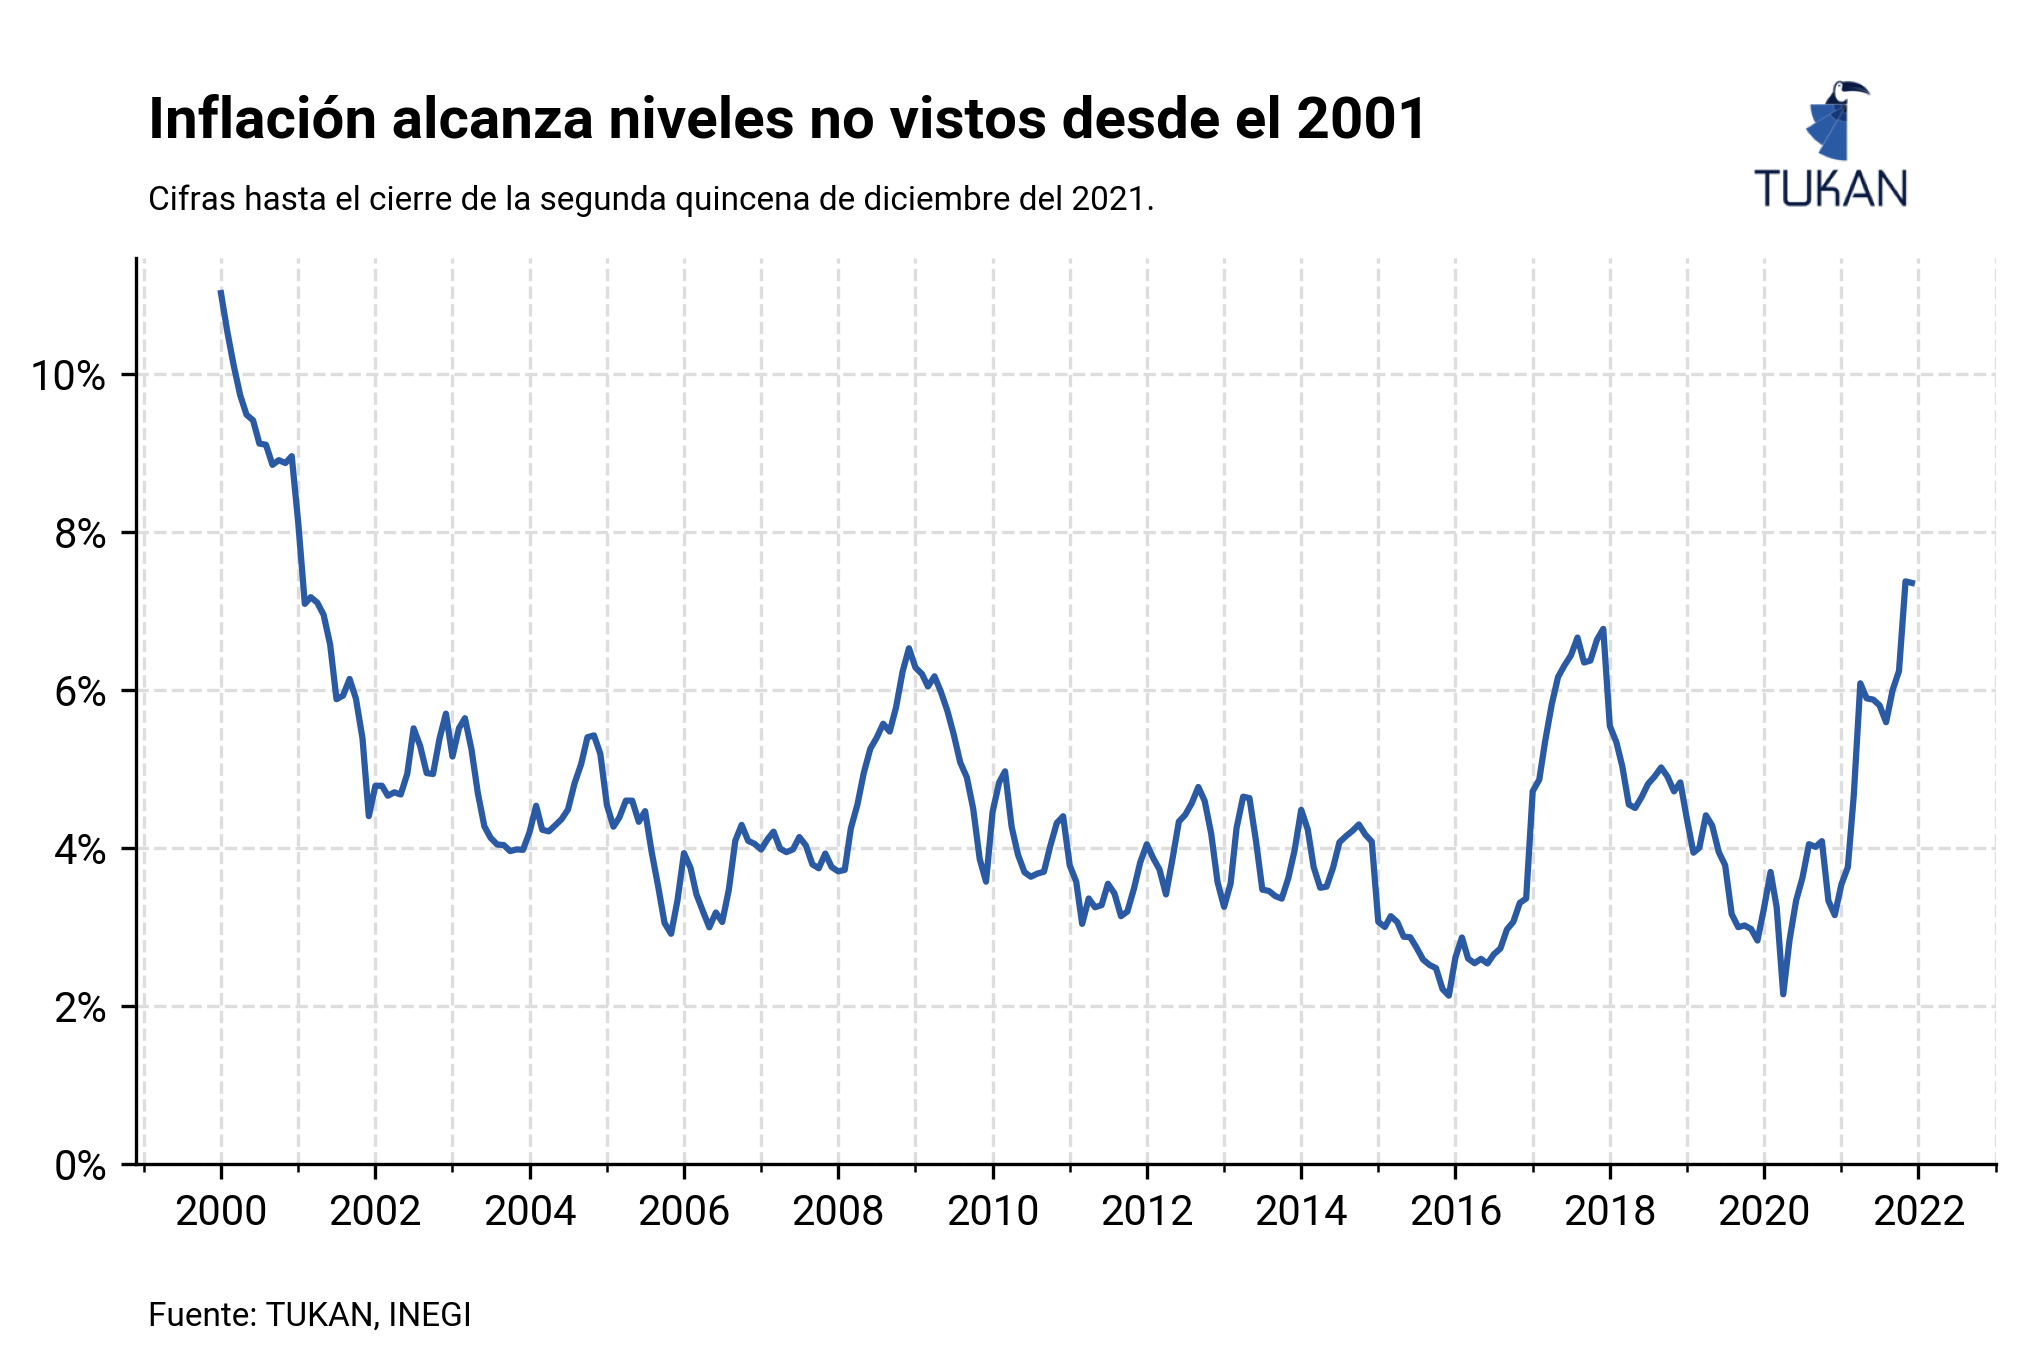

In [137]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

ax.plot(inflation["date"], inflation["c572db59b8cd109"])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylim(0)

fig.text(
    0.13,
    .98,
    "Inflación alcanza niveles no vistos desde el 2001",
    size=14,
    weight = "bold"
)
fig.text(
    0.13,
    0.92,
    "Cifras hasta el cierre de la segunda quincena de diciembre del 2021.",
    size=8
)
# Add footer
fig.text(0.13, -0.01, "Fuente: TUKAN, INEGI", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/inflation_ts_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/inflation_ts_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/inflation_ts_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

ipykernel_launcher:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


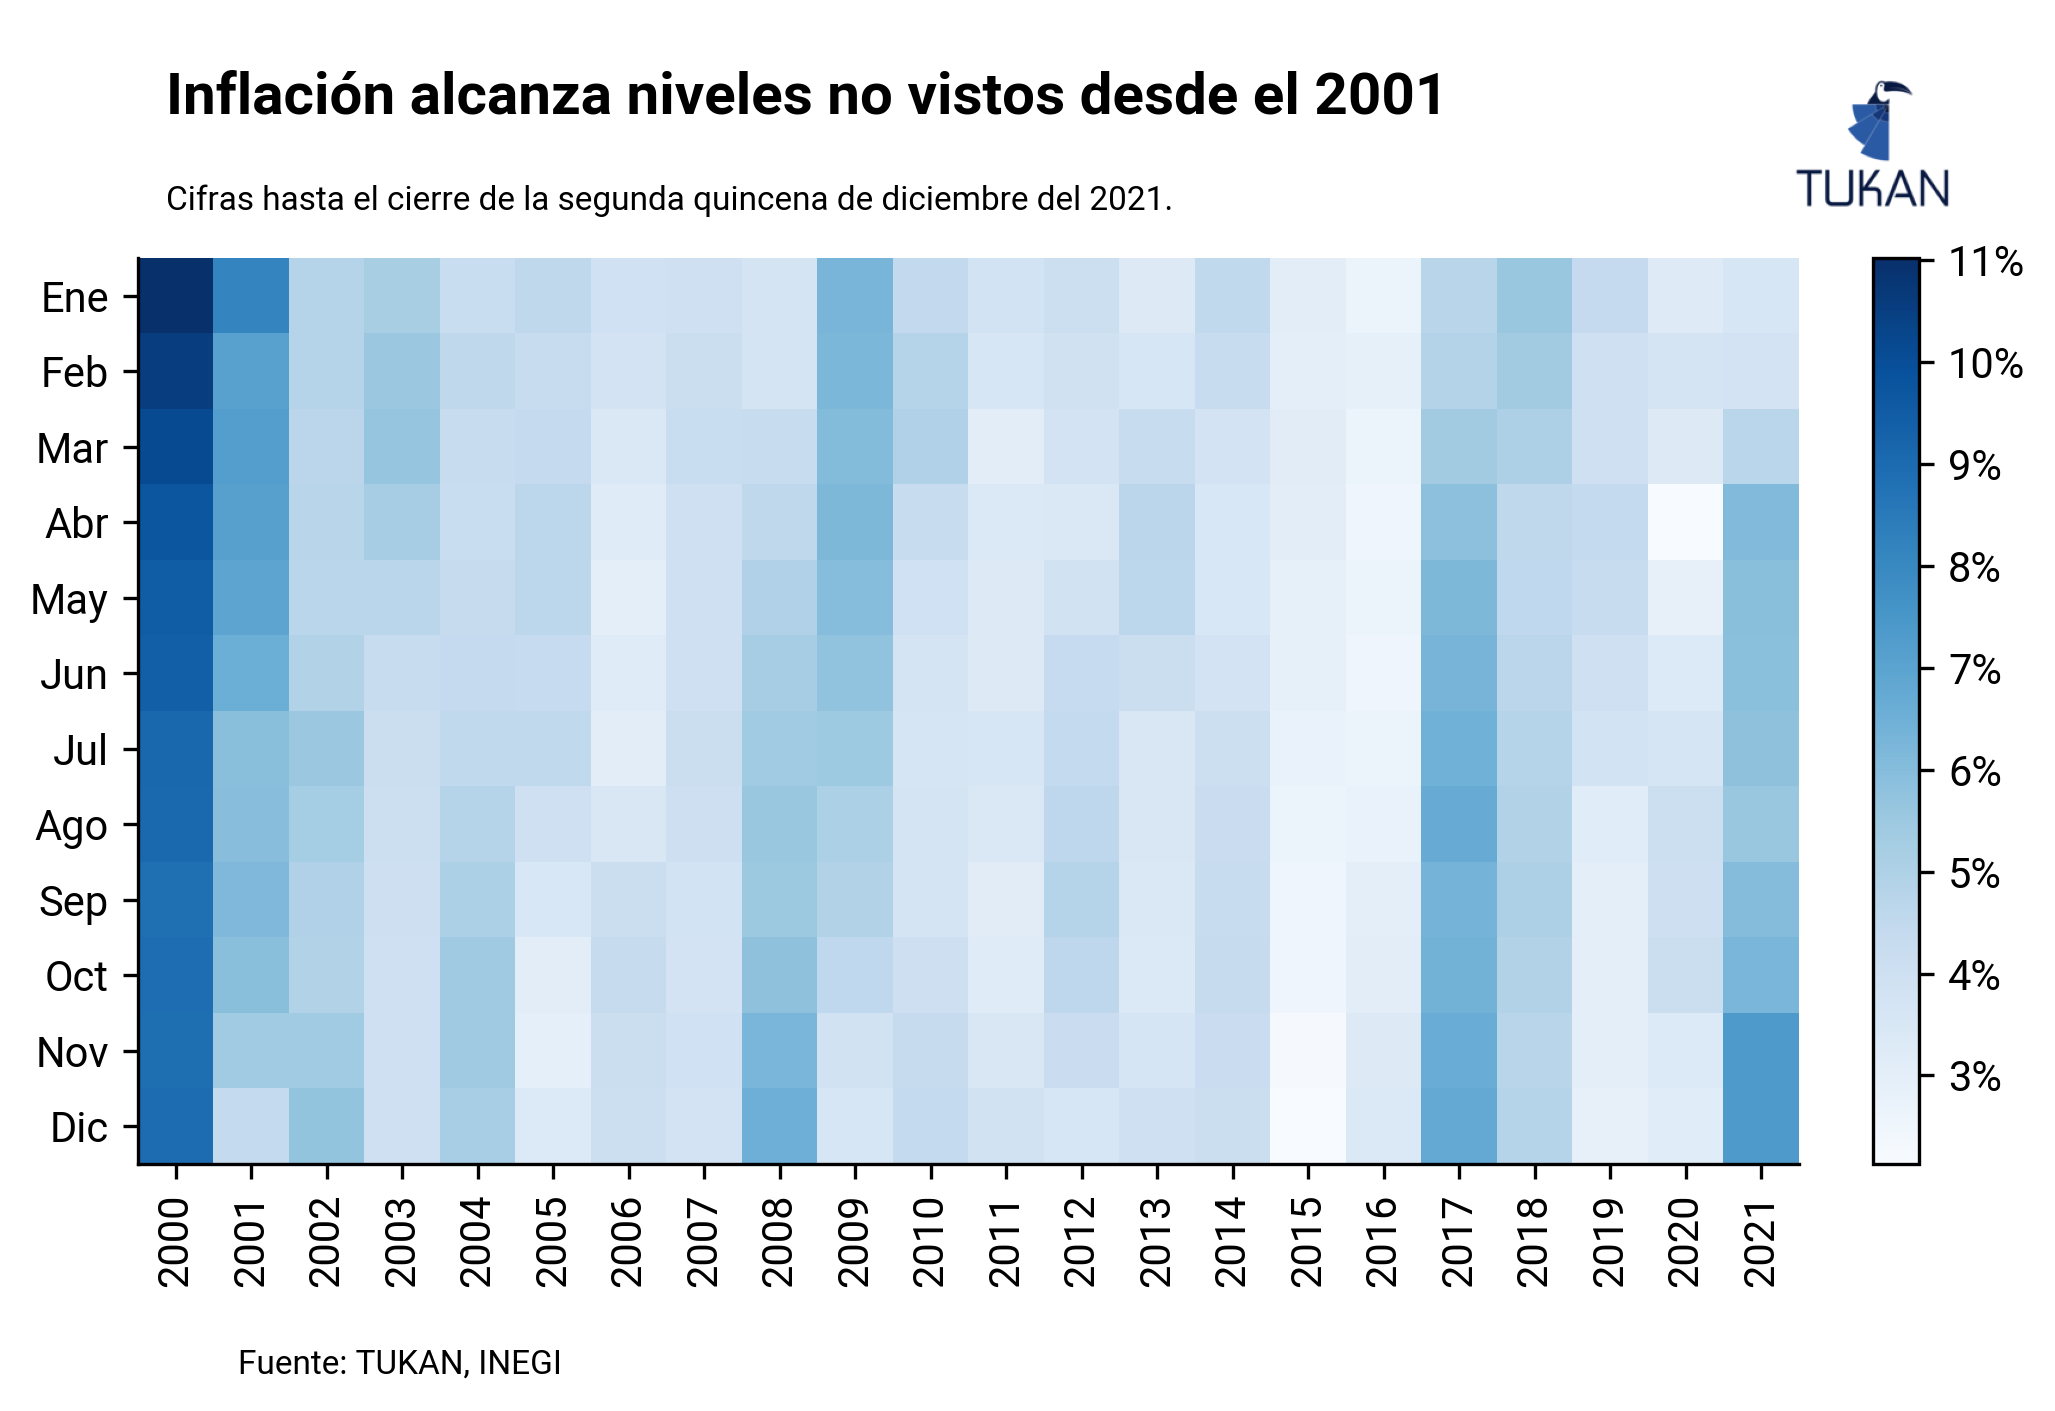

In [112]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
heatmap=ax.imshow(inflation.values, zorder=2, cmap = "Blues")

# Add gridlines and format to ticks 
ax.set_yticks(np.arange(len(month_ticks)), labels=month_ticks)
ax.set_xticks(np.arange(len(year_ticks)), labels=year_ticks, rotation=90)
# ax.grid(which="major", color="w", linestyle='-', linewidth=3)
fig.colorbar(heatmap, fraction=0.05, pad=0.04, format = ticker.StrMethodFormatter('{x:,.0%}'))

# Add title and subtitle
fig.text(
    0.15,
    1,
    "Inflación alcanza niveles no vistos desde el 2001",
    size=14,
    weight = "bold"
)
fig.text(
    0.15,
    0.92,
    "Cifras hasta el cierre de la segunda quincena de diciembre del 2021.",
    size=8
)
# Add footer
fig.text(0.18, -0.05, "Fuente: TUKAN, INEGI", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/inflation_heatmap_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.75, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/inflation_heatmap_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/inflation_heatmap_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 4: Inflation (biweekly), Top 10 Products 2021

The inflation rates have not been the same for all products; insights from their specific market conditions are key to understand why the prices have increased so much in the las year.

Let's visualize the most inflated products in 2021.

In [3]:
# Main Paylod
payload ={
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "product"
    ],
    "categories": {
        "product":  [
            "ea449ca29d875e2",
            "ccb328d11952175",
            "8c2158972d9a439",
            "ccfd7adb4647343",
            "10ef80c17e2b1aa",
            "99c94cf400fd2af",
            "b146318fe51b95c",
            "ce5d642f2df731e",
            "aa9fec12e179a94",
            "59037ebf620a3fb"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_inpc_product_biweekly",
            "variables": [
                "c572db59b8cd109"
            ]
        }
    ],
    "from": "2000-01-01"
}
response = get_tukan_api_request(payload)

Success getting the data


Data manipulation.

In [4]:
p_inflation = response["data"]

# Filter the most inflated products of the most recent year
max_date = p_inflation['date'].max()
max_year = max_date.year
month_filter = max_date.month
min_year = p_inflation['date'].min().year
top_10_df = p_inflation[(p_inflation["date"].dt.year == max_year) & (p_inflation["date"].dt.month == month_filter) ]
top_10_df = top_10_df.sort_values('c572db59b8cd109', ascending=False).reset_index(drop=True)
top_10_df = top_10_df.head(10).copy()
top_10_df.rename(columns={'c572db59b8cd109':str(max_year)},inplace=True)
top_10 = top_10_df['product'].unique().tolist()

# Filter the product's historic inflation rate for the same biweek of previous years
p_inflation = p_inflation[p_inflation["product"].isin(top_10)].reset_index(drop=True)
aux_df = pd.DataFrame()
range_year = np.arange(1, max_year - min_year).tolist()
for x in range_year:
    lag_date = max_date - relativedelta(years = x)
    temp = p_inflation[p_inflation['date'].isin([lag_date])].reset_index(drop=True)
    aux_df = aux_df.append(temp)
aux_df = aux_df.groupby(['product__ref','product']).mean().reset_index()
aux_df.rename(columns={'c572db59b8cd109':'hist_avg'},inplace=True)
top_10_df = top_10_df.merge(aux_df, how='left',on=['product__ref','product'])

# Rename variables
top_10_df = top_10_df.replace({'Tortillas de maíz':'Tortillas \nde maíz',
                               'Loncherías, fondas, torterías y taquerías':'Taquerías \ny fondas',
                               'Leche pasteurizada y fresca':'Leche',
                               'Universidades y politécnicos':'Educación \nsuperior',
                               'Renta de vivienda': 'Renta \nde vivienda',
                               'Casa residencial': 'Casa \nresidencial'
})
top_10_df.reset_index(drop=True, inplace=True)

In [5]:
top_10_df

,date,product__ref,product,2022,hist_avg
0,2022-01-01,b146318fe51b95c,Tortillas \nde maíz,0.176427,0.068955
1,2022-01-01,ccb328d11952175,Taquerías \ny fondas,0.089490,0.055448
2,2022-01-01,99c94cf400fd2af,Automóviles,0.087587,0.025352
3,2022-01-01,aa9fec12e179a94,Leche,0.084627,0.050011
4,2022-01-01,8c2158972d9a439,Restaurantes,0.074319,0.047477
5,2022-01-01,10ef80c17e2b1aa,Refrescos,0.067677,0.051404
6,2022-01-01,59037ebf620a3fb,Cerveza,0.031154,0.046122
7,2022-01-01,ccfd7adb4647343,Renta \nde vivienda,0.026837,0.031916
8,2022-01-01,ea449ca29d875e2,Casa \nresidencial,0.024133,0.030638
9,2022-01-01,ce5d642f2df731e,Educación \nsuperior,0.023918,0.058935


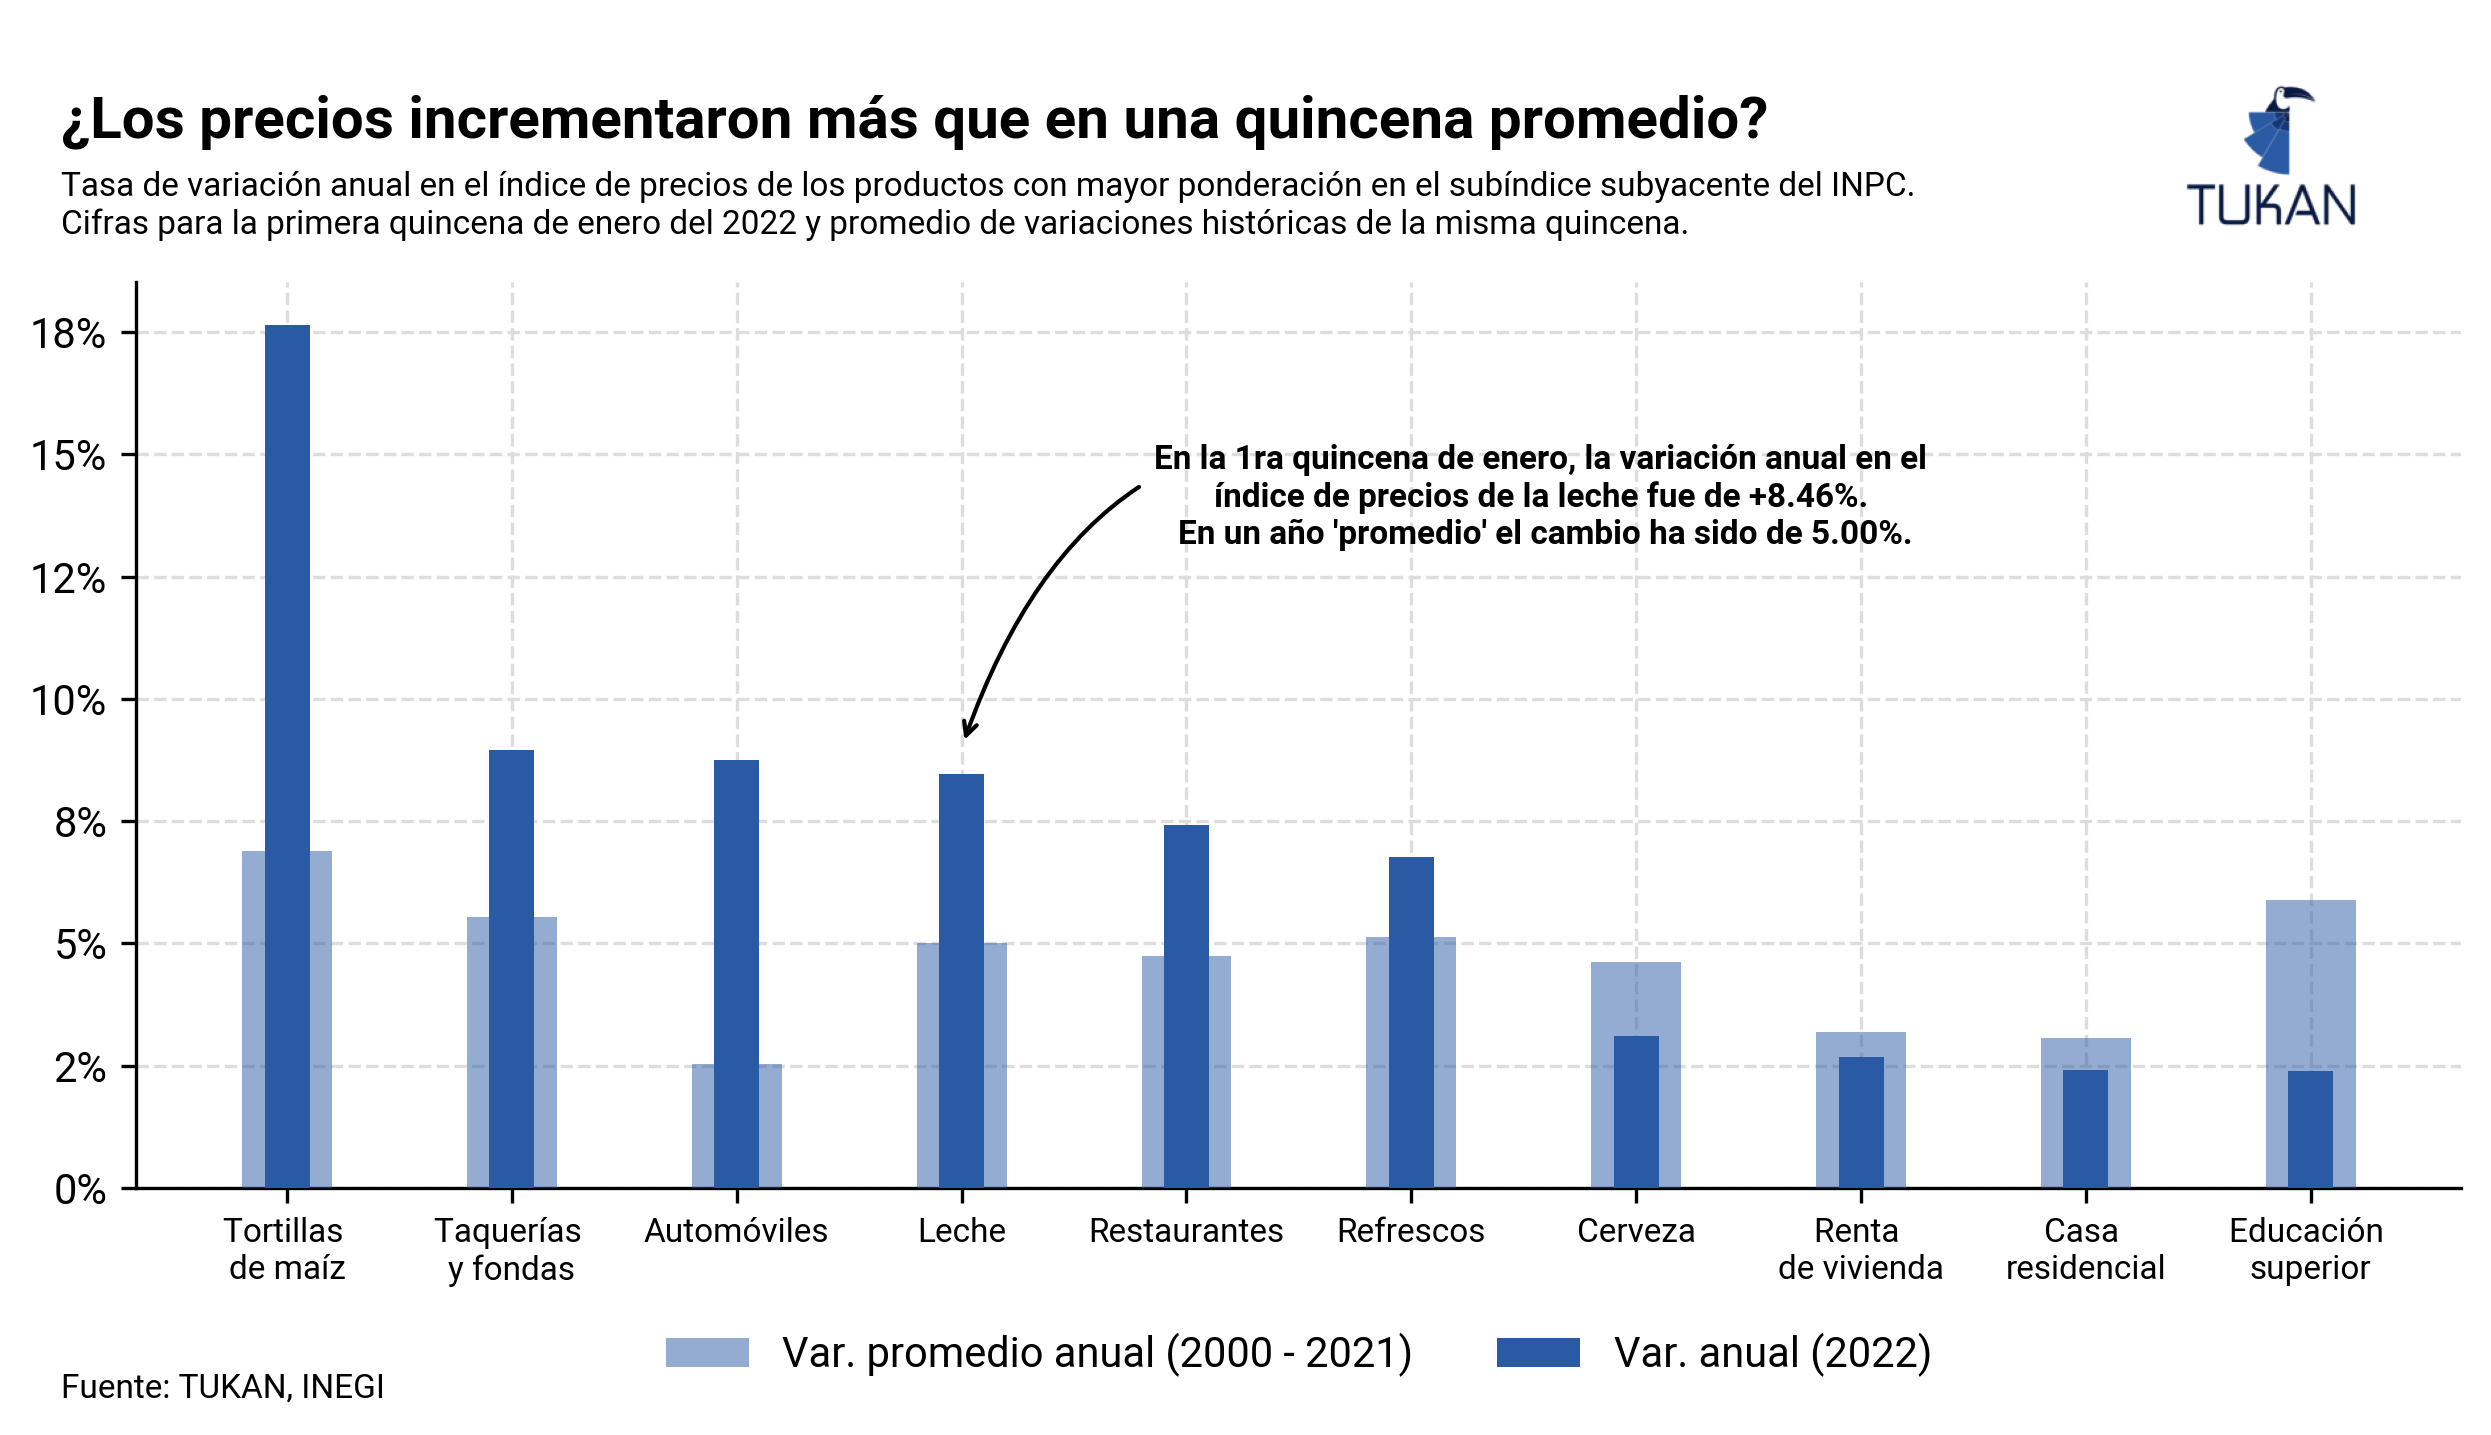

In [23]:
fig = plt.figure(dpi=300, figsize=(10,4))
ax = plt.subplot(111)

# Data to plot
ax.bar(top_10_df["product"],top_10_df["hist_avg"], label='Var. promedio anual (2000 - 2021)', zorder = 3, width = 0.2*2, alpha = 0.5,)
ax.bar(top_10_df["product"],top_10_df["2022"], zorder=3, label='Var. anual (2022)', color="#2B5AA5", width=0.2)

# Add gridlines and format to ticks 
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol = 2)
plt.xticks(rotation='0', size = 8)

# Add title and subtitle
fig.text(
    0.1,
    1,
    "¿Los precios incrementaron más que en una quincena promedio?",
    size=14,
    weight = "bold"
)

fig.text(
    0.1,
    0.92,
    "Tasa de variación anual en el índice de precios de los productos con mayor ponderación en el subíndice subyacente del INPC.\nCifras para la primera quincena de enero del 2022 y promedio de variaciones históricas de la misma quincena.",
    size=8
)

# Add footer
fig.text(0.1, -0.05, "Fuente: TUKAN, INEGI", fontsize=8)

ax.annotate(
    "En la 1ra quincena de enero, la variación anual en el \níndice de precios de la leche fue de +8.46%. \nEn un año 'promedio' el cambio ha sido de 5.00%.",
    xy=(3,.09),
    xycoords="data",
    xytext=(140, 60),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="center",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=.55"
    ),
)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/inflation_products_no_logo.svg",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.7, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/inflation_products_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/inflation_products_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 5: Exchange rate 2021

Let's visualize the exchange rate evolution

In [95]:
# Main payload
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        ""
    ],
    "categories": {},
    "request": [
        {
            "table": "mex_banxico_cf102",
            "variables": [
                "b81e60ba1288ef6"
            ]
        }
    ],
    "from": "2021-01-01"
}

response = get_tukan_api_request(payload)

Success getting the data


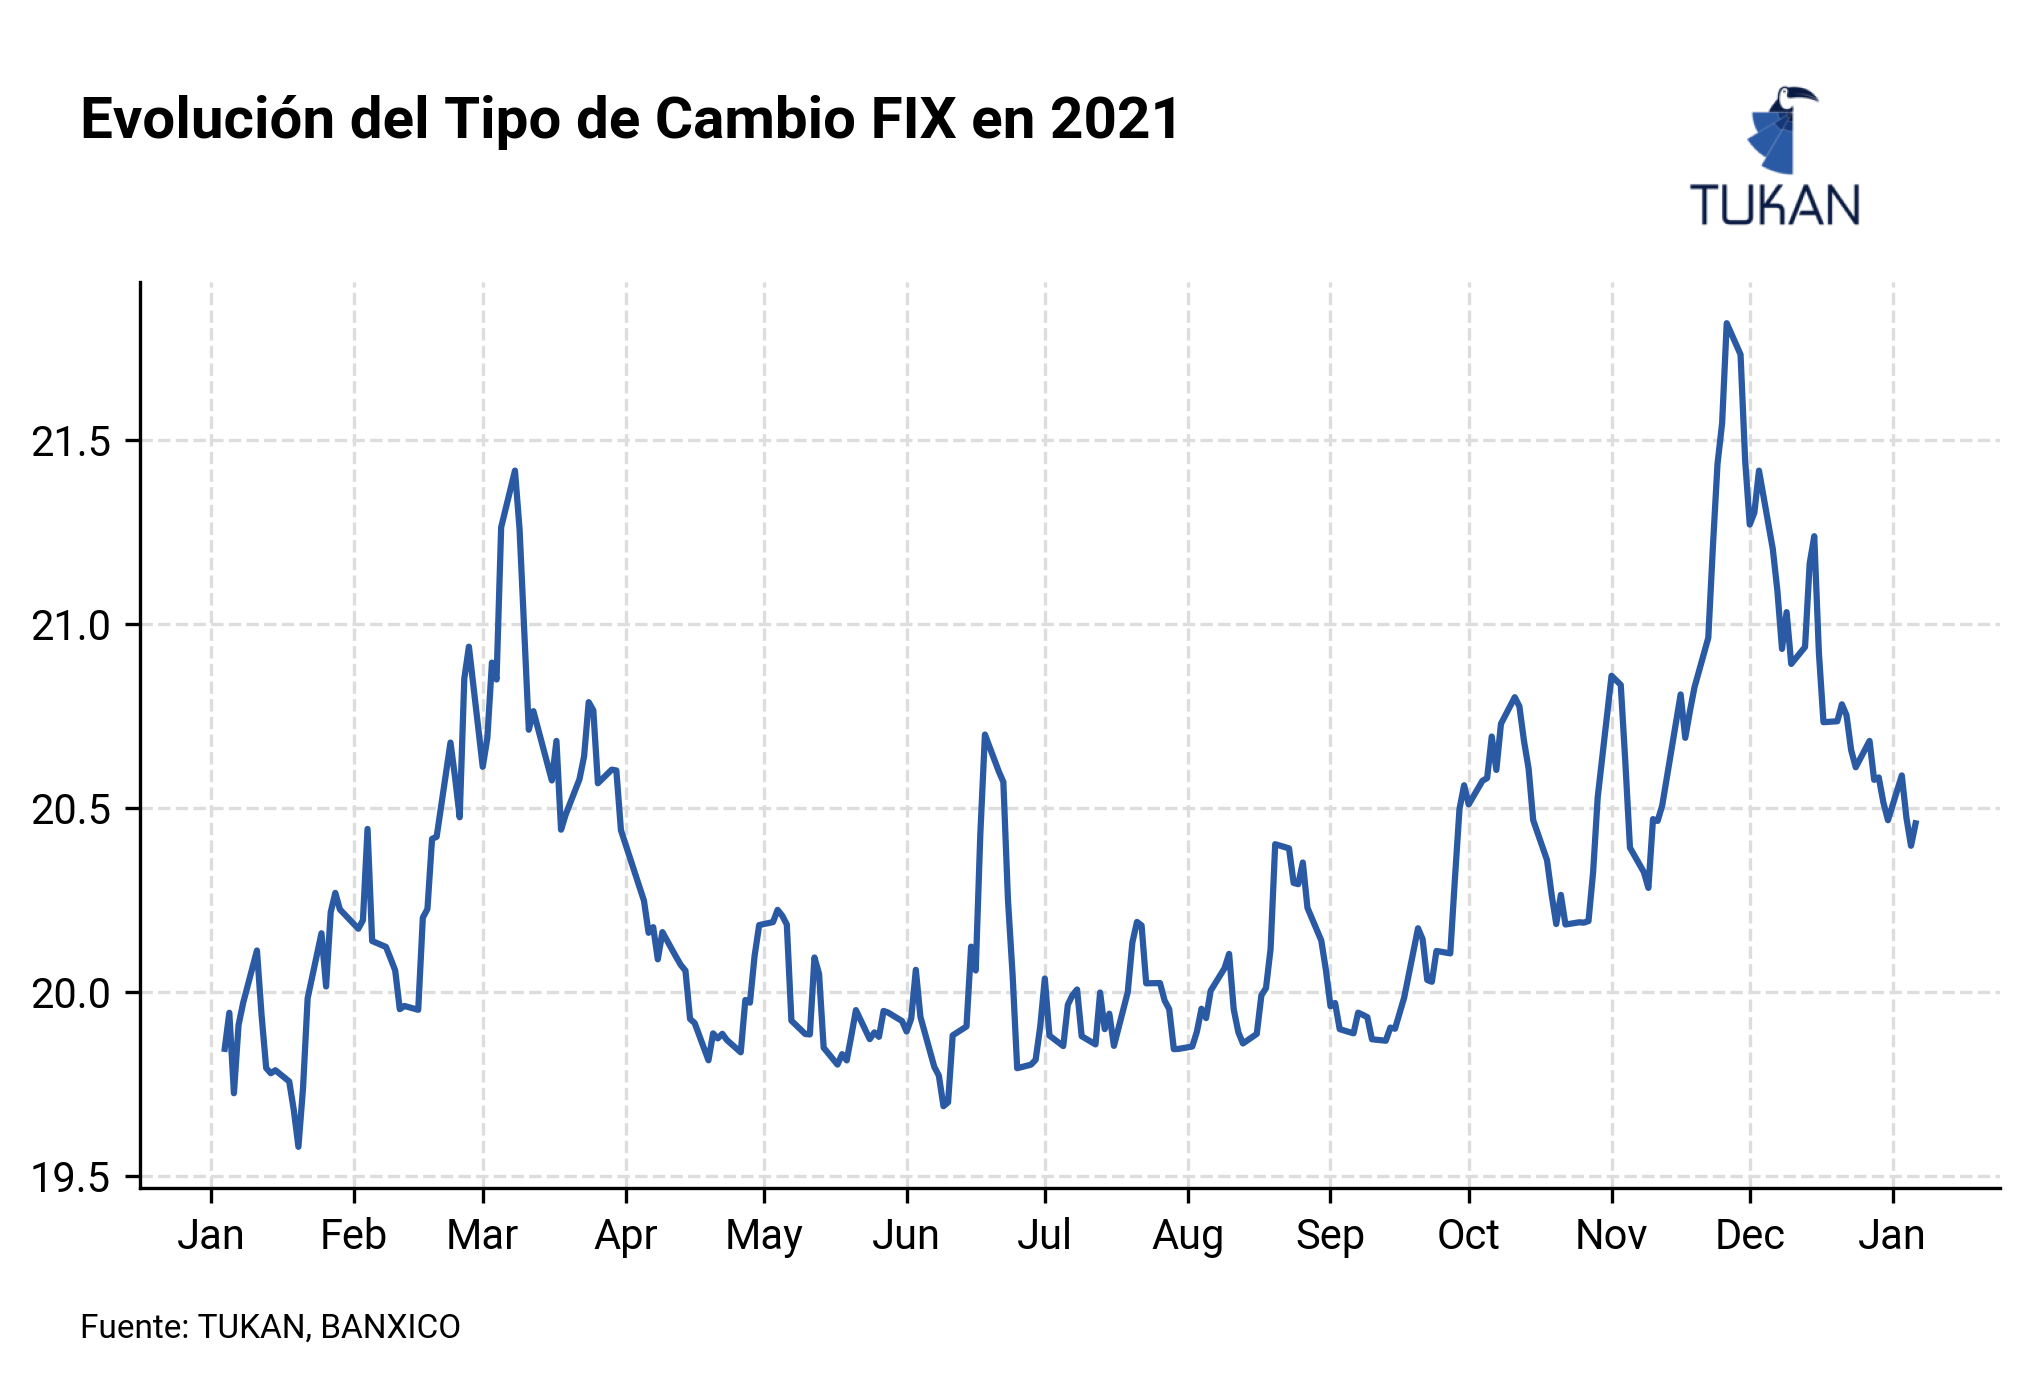

In [96]:
exchange_rate = response['data']

fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.plot(exchange_rate['date'],exchange_rate['b81e60ba1288ef6'])

# Add gridlines and format to ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:0}'))
# plt.xticks(rotation='vertical')

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
# Specify formatter
ax.xaxis.set_major_formatter(fmt)

# Add title and subtitle
fig.text(
    0.1,
    1,
    "Evolución del Tipo de Cambio FIX en 2021",
    size=14,
    weight = "bold"
)

# Add footer
fig.text(0.1, -0, "Fuente: TUKAN, BANXICO", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/exchange rate_no_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.68, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/exchange rate_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/exchange rate_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)


## Chart 6: Manufacturing Exports by destination

Mexico's main commercial partner is undoubtedly the USA, but has its export value to it has grown relative to the rest of the world?

In [97]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity",
        "geography"
    ],
    "categories": {
        "economic_activity": [
            "dfeefc621d16d0c"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_banxico_ce171",
            "variables": [
                "b787e79312e956f"
            ]
        }
    ],
    "from": "2020-01-01"
}
response = get_tukan_api_request(payload)
exports = response['data']


Success getting the data


Let's focus first on the Monthly export value relative rate between the USA and the rest of the world. 

Fancy, data manipulation?

In [98]:
# Divide by a million
exports['b787e79312e956f'] = exports['b787e79312e956f'] /1000000

# Filter USA data
exports_geography = exports[exports['geography__ref']=='e7f97f162f2d08a'].copy()
exports_geography.rename(columns={'b787e79312e956f':'usa_level'}, inplace=True)
exports_geography = exports_geography[['date','usa_level']]

# Filter World data
aux_df = exports[exports['geography__ref']=='2064d512d0da97d'].copy()
aux_df.rename(columns={'b787e79312e956f':'world_level'}, inplace=True)
aux_df = aux_df[['date','world_level']]
exports_geography = exports_geography.merge(aux_df, how='left', on ='date')

# Exclud USA exports from the worl and calculate rates
exports_geography['world_level'] = exports_geography['world_level'] - exports_geography['usa_level']
exports_geography['world_rate'] = exports_geography['world_level'].shift(1)
exports_geography['world_rate'] = (exports_geography['world_level']/exports_geography['world_rate']) -1 
exports_geography['usa_rate'] = exports_geography['usa_level'].shift(1)
exports_geography['usa_rate'] = (exports_geography['usa_level']/exports_geography['usa_rate']) -1 
exports_geography = exports_geography[exports_geography['date']>='2021-01-01'].reset_index(drop=True)
exports_geography['usa_level/world_level'] = exports_geography['usa_level'] / exports_geography['world_level']
exports_geography

,date,usa_level,world_level,world_rate,usa_rate,usa_level/world_level
0,2021-01-01,23550.026,5100.013,-0.165051,-0.276964,4.617640
1,2021-02-01,26313.551,5505.920,0.079589,0.117347,4.779138
2,2021-03-01,31751.017,5957.652,0.082045,0.206641,5.329451
3,2021-04-01,29994.188,6386.664,0.072010,-0.055331,4.696378
4,2021-05-01,29439.920,6591.490,0.032071,-0.018479,4.466353
5,2021-06-01,30998.142,6367.648,-0.033959,0.052929,4.868068
6,2021-07-01,30124.327,5835.263,-0.083608,-0.028189,5.162463
7,2021-08-01,29676.596,5880.215,0.007704,-0.014863,5.046856
8,2021-09-01,31724.711,5638.024,-0.041187,0.069014,5.626920
9,2021-10-01,31266.932,5507.672,-0.023120,-0.014430,5.676978


Finally, plot time once more.

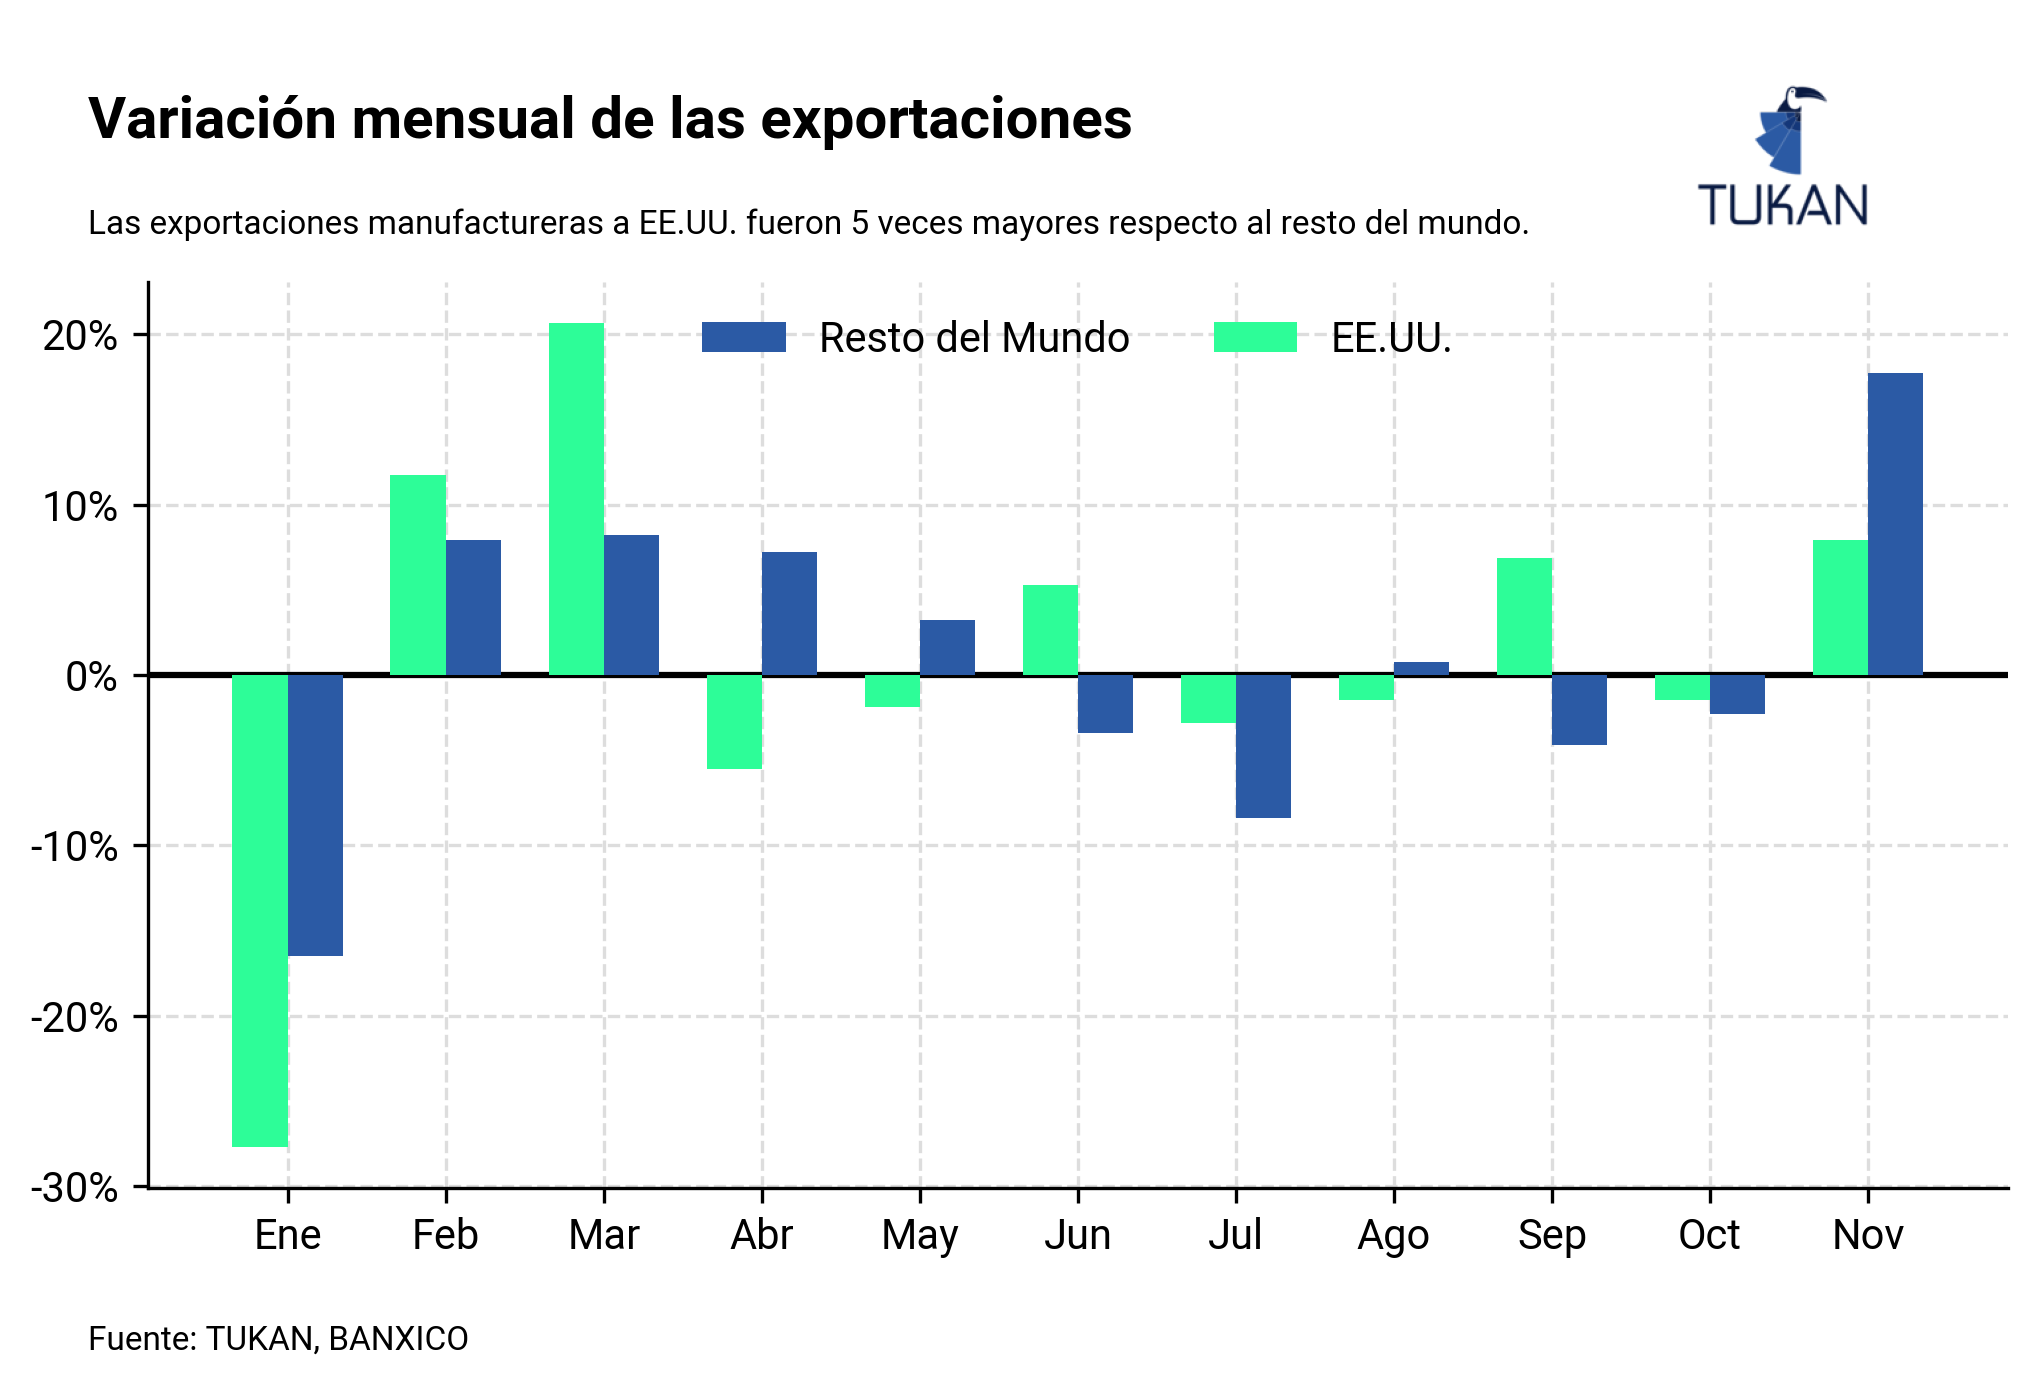

In [99]:
labels=['Ene', 'Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov']
x = np.arange(len(labels))
width = 0.35

fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
ax.axhline(y=0, color='black', linestyle='-')
rects1 = ax.bar(x + width/2, exports_geography["world_rate"], width, label='Resto del Mundo', zorder = 2)
rects2 = ax.bar(x - width/2, exports_geography["usa_rate"], width, label='EE.UU.',zorder = 2)

# # Add gridlines and format to ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0%}'))
ax.set_xticks(x, labels)
ax.legend(loc="upper center", ncol = 3)

# Add title and subtitle
fig.text(
    0.1,
    1,
    "Variación mensual de las exportaciones",
    size=14,
    weight = "bold"
)

fig.text(
    0.1,
    0.92,
    "Las exportaciones manufactureras a EE.UU. fueron 5 veces mayores respecto al resto del mundo.",
    size=8
)

# Add footer
fig.text(0.1, -0.01, "Fuente: TUKAN, BANXICO", fontsize=8)

# # Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/exports_no_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.68, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/exports_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/exports_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 7: Automotive Exports

The Manufacturing related activities in the country is lead by the Automotive industry, what is the automovite contribution share, relative to the whole manufactured goods? 

In [100]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "economic_activity",
        "geography"
    ],
    "categories": {
        "economic_activity": [
            "faa2a8d0af8a72c",
            "957ec95cb84292e"
        ],
        "geography": [
            "2064d512d0da97d"
        ]
    },
    "request": [
        {
            "table": "mex_banxico_ce171",
            "variables": [
                "b787e79312e956f"
            ]
        }
    ],
    "from": "2021-01-01"
}
response = get_tukan_api_request(payload)

Success getting the data


In [101]:
# Data
exports_auto = response['data']

# Divide by millions and pivot data
exports_auto['b787e79312e956f'] = exports_auto['b787e79312e956f']/1000000 
exports_auto = exports_auto.pivot(index = "date", columns='economic_activity', values='b787e79312e956f').reset_index()
exports_auto.rename(columns={'Fabricación de partes y vehículos automotrices':'Industria Automotriz',
                             'Industrias manufactureras':'Manufactura Total',
                             }, inplace=True)
exports_auto['Otros Productos'] = exports_auto['Manufactura Total'] - exports_auto['Industria Automotriz']
exports_auto['auto_mkt_share'] = exports_auto['Industria Automotriz']/exports_auto['Manufactura Total']
exports_auto

economic_activity,date,Industria Automotriz,Manufactura Total,Otros Productos,auto_mkt_share
0,2021-01-01,10379.585,28650.039,18270.454,0.362289
1,2021-02-01,10811.994,31819.471,21007.477,0.339792
2,2021-03-01,11957.244,37708.669,25751.425,0.317095
3,2021-04-01,12594.922,36380.852,23785.930,0.346196
4,2021-05-01,12539.485,36031.410,23491.925,0.348015
5,2021-06-01,11965.795,37365.790,25399.995,0.320234
6,2021-07-01,10442.712,35959.590,25516.878,0.290401
7,2021-08-01,10702.290,35556.811,24854.521,0.300991
8,2021-09-01,11299.844,37362.735,26062.891,0.302436
9,2021-10-01,10928.259,36774.604,25846.345,0.297169


In [102]:
exports_auto['auto_mkt_share'].mean()

0.3239375341237479

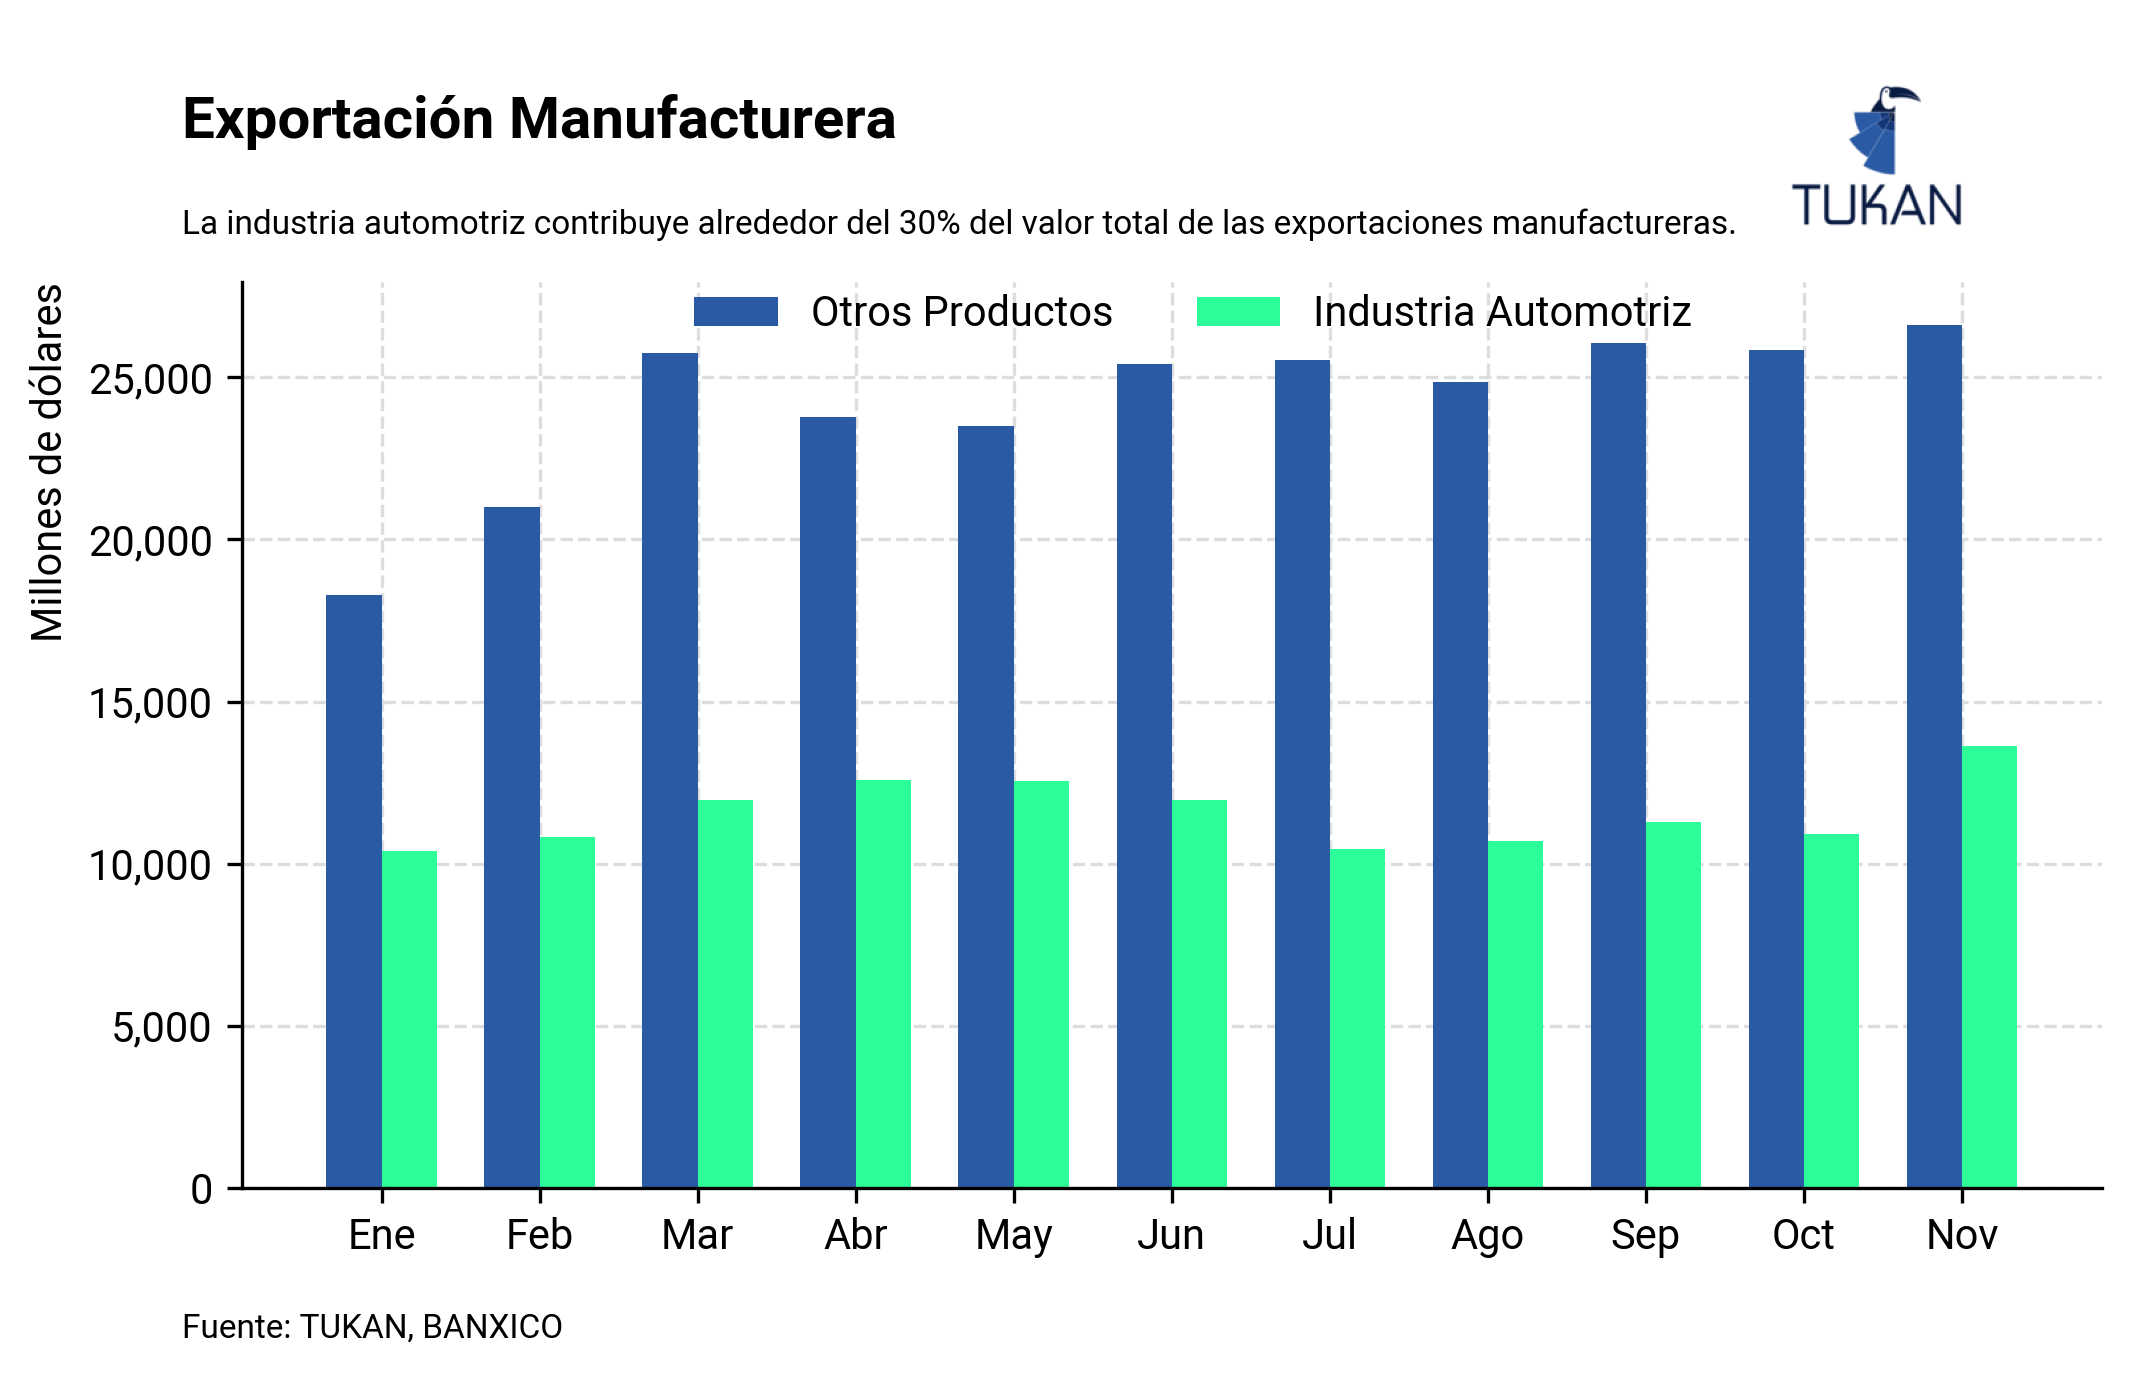

In [103]:
# Chart format
labels=['Ene', 'Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov']
x = np.arange(len(labels))
width = 0.35

fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
rects1 = ax.bar(x - width/2, exports_auto["Otros Productos"], width, label='Otros Productos', zorder = 2)
rects2 = ax.bar(x + width/2, exports_auto["Industria Automotriz"], width, label='Industria Automotriz',zorder = 2)
# ax.bar(exports_auto["date"],exports_auto["Manufactura total"], zorder=2, label='Manufactura Total')

# # Add gridlines and format to ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Millones de dólares', loc='top')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(0.8, 0.9), ncol = 2) #loc="upper center"


# # Add title and subtitleren
fig.text(
    0.1,
    1,
    "Exportación Manufacturera",
    size=14,
    weight = "bold"
)

fig.text(
    0.1,
    0.92,
    "La industria automotriz contribuye alrededor del 30% del valor total de las exportaciones manufactureras.",
    size=8
)

# # Add footer
fig.text(0.1, -0, "Fuente: TUKAN, BANXICO", fontsize=8)

# # Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/automotive_no_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.68, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/automotive_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/automotive_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 8: Light Vehicles Production and Sales
The social distancing measures of 2020, in addition to labor market disruptions, had it toll on the automotive market; This years chip manufacturing industry shortages plus the supply chain issues added to it.

Let's dive into the data.

# 